**1. Problem Statement**:
"Analyzing Connecticut Real Estate Sales: Assessing the Impact of Property Type and Assessment Values on Sales Prices"

**Research Questions**:
1. "How do sales prices vary across different property types (residential, apartment, commercial, industrial, and vacant land) in Connecticut?"
2. "Is there a correlation between property assessment values and actual sales prices for real estate transactions in Connecticut?"
3. "What are the trends in real estate sales prices over the years, considering the annual reporting cycle from October 1 to September 30?"


**Objective:**
The objective of this project is to utilize the real estate sales dataset provided by the Office of Policy and Management in Connecticut to understand the factors influencing property sales prices. By exploring the relationships between property types, assessment values, and sales prices, the analysis aims to provide insights into the Connecticut real estate market and contribute valuable information for potential homebuyers, sellers, and policymakers.

This project aims to provide valuable insights into the Connecticut real estate market, offering a comprehensive understanding of key factors influencing property.

**Data Source:**

Two seperate datasets were used to acheive the aim of the project.



**A. Sales Dataset:**

---

The first data for this analysis was obtained from the Office of Policy and Management's real estate sales records, as mandated by Connecticut General Statutes, section 10-261a and 10-261b. The dataset includes information on town, property address, date of sale, property type, sales price, and property assessment, accessed through https://catalog.data.gov/dataset/real-estate-sales-2001-2018




Source: Office of Policy and Management, Connecticut



Collection Period: October 1 to September 30 each year from 2001 to 2020

**Columns:**

**1. Serial Number**

> Format: Numeric/ Integers

>   Description: Unique identifier for each property sale record

**2. List Year:**
> Format: Numeric/Integers

>   Description: The year in which the property was listed for sales record

**3. Date Recorded:**
> Format: Numeric/ Object

>   Description: Date when the property sales was recorded

**4. Town:**
> Format: Text / Object

>   Description: Town where the property is located in Connecticut

**5. Address:**
> Format: Text / Object

>   Description: Address of the property in Connecticut

**6. Assessed Value:**
> Format: Numeric/Float

>   Description: Assessment value of the property

**7. Sale Amount:**
> Format:  Numeric/Float

>   Description: Price at which the property was sold

**8. Sales Ratio:**  
> Format:  Numeric/Float

>   Description: Ratio of Sale Amount to Assessed Value

**9. Property Type**:
> Format: Text / Object

>   Description: Type of the property (Residential, Apartments, Commercial, Industrial, Vacant land, Public Utility).

For the pupose of this study, Condo, Single Family, Two Family, Three Family and Four Family buildings are classified as Residential properties.

**10. Residential Type:**  
> Format: Text / Object


>   Description: Specific type within residential properties (Condo, Single Family, Two Family, Three Family, Four Family)

**11. Location:**
> Format: Text / Object

>   Description: Point coordinates of the property (latitude, longitude)




**B. Geospatial Data:**

---




Dataset Name: TIGER/Line Shapefile, 2019, state, Connecticut, Current County Subdivision State-based

Source: U.S. Census Bureau's Master Address File / Topologically Integrated Geographic Encoding and Referencing (MAF/TIGER) Database (MTDB). Acessed through https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-connecticut-current-county-subdivision-state-based

Update Date: October 12, 2021

**Columns Added:**

**1. GEOID**: Unique codes associated with specific geographic areas
 Format: Numeric/ Object


**2. NAME:**  Same as Town above. Which is the different towns in Connecticut

 Format: Text / Object

**3. geometry**: Contains polygon geometries (longitudes, latitudes) based on the geocoded towns.

Format: Polygons/Goemetry



**2. Data Collection**

In [87]:
#import pandas, numpy, matplotlib, geopandas, seaborn,  ---
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.wkt import loads
import seaborn as sns
import plotly.express as px
import plotly.express as px
import zipfile
import io
import requests

In [88]:
# Load the real estate sales records data and convert the Date Recorded column to datetime data type
fname = "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"
data = pd.read_csv(fname,low_memory=False)
#Drop columns not needed
data = data.drop(columns=['Non Use Code', 'Assessor Remarks', 'OPM remarks'])
data

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.460600,Residential,Three Family,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.463000,Commercial,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.629100,Residential,Two Family,NaN
4,200500,2020,09/07/2021,Avon,245 NEW ROAD,217640.0,400000.0,0.544100,Residential,Single Family,NaN
...,...,...,...,...,...,...,...,...,...,...,...
997208,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.137665,Single Family,Single Family,NaN
997209,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.0,76000.0,0.898400,Single Family,Single Family,NaN
997210,190129,2019,04/27/2020,Windsor Locks,19 HATHAWAY ST,121450.0,210000.0,0.578300,Single Family,Single Family,NaN
997211,190504,2019,06/03/2020,Middletown,8 BYSTREK DR,203360.0,280000.0,0.726300,Single Family,Single Family,NaN


In [89]:
# URL of the shapefile zip file (Load the Connecticut Shapefile)
shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUSUB/tl_2019_09_cousub.zip"

# Download and extract the shapefile
zname = requests.get(shapefile_url)
with zipfile.ZipFile(io.BytesIO(zname.content), 'r') as z:
    z.extractall()

# Load the shapefile into a GeoDataFrame
zshps = gp.read_file('tl_2019_09_cousub.shp')
zshps
#Drop less important columns in the zshps GeoDataFrame
zshps = zshps[["GEOID", "NAME", "geometry"]]
zshps

,GEOID,NAME,geometry
0,0900560750,Plymouth,"POLYGON ((-73.06467 41.64182, -73.06439 41.643..."
1,0900100000,County subdivisions not defined,"POLYGON ((-73.45646 40.99116, -73.45646 41.013..."
2,0900156060,Norwalk,"POLYGON ((-73.47456 41.11470, -73.47441 41.114..."
3,0900104720,Bethel,"POLYGON ((-73.43502 41.37240, -73.43457 41.373..."
4,0900108070,Bridgeport,"POLYGON ((-73.24409 41.22660, -73.24340 41.226..."
...,...,...,...
168,0901171670,Sprague,"POLYGON ((-72.11857 41.66164, -72.11328 41.660..."
169,0901178600,Voluntown,"POLYGON ((-71.88442 41.64120, -71.88439 41.641..."
170,0901180280,Waterford,"POLYGON ((-72.21931 41.41212, -72.21746 41.412..."
171,0901562710,Putnam,"POLYGON ((-71.93367 41.91687, -71.93335 41.916..."


In [90]:
#YOU CAN USE THIS PROCESS IF YOU HAVE THE FILE DOWNLOADED
# #Load the already downloaded Connecticut shapefile
# from google.colab import drive
# drive.mount("/content/drive")
# zname = "/content/drive/MyDrive/tl_2019_09_cousub (1)/tl_2019_09_cousub.shp"
# zshps = gp.read_file(zname)
# #Drop less important columns in the zshps GeoDataFrame
# zshps = zshps[["GEOID", "NAME", "geometry"]]
# zshps

**3. Data Preparation:**

In [91]:
# Checks for NAs in the dataframe
data.isna().sum()

Serial Number            0
List Year                0
Date Recorded            2
Town                     0
Address                 51
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       382446
Residential Type    388309
Location            799516
dtype: int64

In [92]:
#check the data types for all the data frame.
data.dtypes

Serial Number         int64
List Year             int64
Date Recorded        object
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Location             object
dtype: object

The original dataset incorporates Condo, Single Family, Two Family, Three Family, and Four Family Buildings under the Property Type classification, which is meant to fall under the Residential property type. Therefore, I will be replacing all Condo, Single Family, Two Family, Three Family, and Four Family buildings with the classification 'Residential' in the Property Type column.

In [93]:
#Replacing all Condo, Single Family, Two Family, Three Family, and Four Family with "Residential." in the Property type Column
# Change data type to string
data['Property Type'] = data['Property Type'].astype(str)

# Replace values in the 'Property Type' column
replacement_dict = {
    'Single Family': 'Residential',
    'Two Family': 'Residential',
    'Three Family': 'Residential',
    'Four Family': 'Residential',
    'Condo': 'Residential'
}

data['Property Type'].replace(replacement_dict, inplace=True)
data

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.460600,Residential,Three Family,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.463000,Commercial,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.629100,Residential,Two Family,NaN
4,200500,2020,09/07/2021,Avon,245 NEW ROAD,217640.0,400000.0,0.544100,Residential,Single Family,NaN
...,...,...,...,...,...,...,...,...,...,...,...
997208,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.137665,Residential,Single Family,NaN
997209,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.0,76000.0,0.898400,Residential,Single Family,NaN
997210,190129,2019,04/27/2020,Windsor Locks,19 HATHAWAY ST,121450.0,210000.0,0.578300,Residential,Single Family,NaN
997211,190504,2019,06/03/2020,Middletown,8 BYSTREK DR,203360.0,280000.0,0.726300,Residential,Single Family,NaN



Handling Missing Location Coordinates for Geospatial Analysis: Removing Null Values from the Original DataFrame's Location Coordinates and Saving the Result as "**data2**"

In [94]:
# drop missing values in the location coordinates and save to new data as data2
data2 = (data.dropna(subset=["Location"])).reset_index()
data2 = data2.drop(columns="index")
data2

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,POINT (-73.06822 41.35014)
1,200121,2020,12/15/2020,Avon,63 NORTHGATE,528490.0,775000.0,0.681900,Residential,Single Family,POINT (-72.89675 41.79445)
2,200207,2020,11/23/2020,Bristol,BROAD PLACE LOTS 225-6 AND 224,8400.0,38500.0,0.218100,Vacant Land,NaN,POINT (-72.90406 41.66996)
3,20188,2020,07/19/2021,Burlington,206 COVEY RD,286860.0,540000.0,0.531200,Residential,Single Family,POINT (-72.97635 41.79258)
4,200192,2020,05/10/2021,East Haddam,96 LONGWOOD DR,83020.0,175000.0,0.474400,Residential,Single Family,POINT (-72.33294 41.51729)
...,...,...,...,...,...,...,...,...,...,...,...
197692,190389,2019,03/24/2020,Norwich,17 VINE ST,86600.0,182000.0,0.475800,Residential,Three Family,POINT (-72.07006 41.53315)
197693,190478,2019,02/14/2020,Norwalk,38 HYATT AVE,283180.0,440000.0,0.643600,Residential,Single Family,POINT (-73.427 41.11112)
197694,190159,2019,07/23/2020,Weston,62 RIDGE ROAD,516990.0,790000.0,0.654400,Residential,Single Family,POINT (-73.38341 41.19079)
197695,190105,2019,02/25/2020,Plymouth,18 OVERLOOK RD,104130.0,80000.0,1.301625,Residential,Single Family,POINT (-72.98492 41.64753)


**Option 2**

"In the same vein, execute the below above to generate the geospatial attribute for the original DataFrame. This code performs geocoding on addresses from the 'Address' column in the data DataFrame, creates point geometries, and appends them to a new 'Geometry' column. Additionally, it introduces a delay between geocoding requests to mitigate rate limits. Lastly, the code produces a copy of the DataFrame (**data2**)."
The other approach was selected given  the considerable size of the dataset and the anticipated duration of the task."




In [95]:
# # Geocoding Addresses and Creating Geospatial Attribute

# import time
# from shapely.geometry import Point
# from geopy.geocoders import Nominatim  # Assuming Nominatim is used for geocoding

# # Initialize variables
# geometry = []

# # Create a geolocator
# geolocator = Nominatim(user_agent="myApp")

# # Iterate over rows
# for index, row in data.iterrows():
#     address = row["Address"]

#     try:
#         # Print current index
#         print(f"Processing row {index} - Address: {address}")

#         # Geocode the address
#         location = geolocator.geocode(address)

#         # Check if location is found
#         if location:
#             point = Point(location.longitude, location.latitude)
#             geometry.append(point)
#         else:
#             geometry.append(None)

#         # Introduce a delay between requests to avoid rate limits
#         time.sleep(1)

#     except Exception as e:
#         print(f"Error geocoding address '{address}': {str(e)}")
#         geometry.append(None)

# # Create a new column "Geometry" in the data DataFrame
# data["Geometry"] = geometry

# # Create a copy of the DataFrame
# data2 = data.copy()

Data Transformation and Geospatial Integration: Converting the Original Dataset into a GeoDataFrame and Merging it with the Connecticut Shapefile


In [96]:
#Convert the data in the location column to geometry.
# Function to extract latitude and longitude from the points coordinates
def extract_lat_long(point_str):
    point = loads(point_str)
    return point.y, point.x

# Apply the function to each row in the DataFrame This code will create a new column with Longitude and Latitude
# data2['Latitude'], data2['Longitude'] = zip(*data2['Location'].apply(extract_lat_long))

# Convert the data to GeoDataFrame
geometry = [loads(point_str) for point_str in data2['Location']]
data2= gp.GeoDataFrame(data2, geometry=geometry, crs='EPSG:4326')
data2

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location,geometry
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,POINT (-73.06822 41.35014),POINT (-73.06822 41.35014)
1,200121,2020,12/15/2020,Avon,63 NORTHGATE,528490.0,775000.0,0.681900,Residential,Single Family,POINT (-72.89675 41.79445),POINT (-72.89675 41.79445)
2,200207,2020,11/23/2020,Bristol,BROAD PLACE LOTS 225-6 AND 224,8400.0,38500.0,0.218100,Vacant Land,NaN,POINT (-72.90406 41.66996),POINT (-72.90406 41.66996)
3,20188,2020,07/19/2021,Burlington,206 COVEY RD,286860.0,540000.0,0.531200,Residential,Single Family,POINT (-72.97635 41.79258),POINT (-72.97635 41.79258)
4,200192,2020,05/10/2021,East Haddam,96 LONGWOOD DR,83020.0,175000.0,0.474400,Residential,Single Family,POINT (-72.33294 41.51729),POINT (-72.33294 41.51729)
...,...,...,...,...,...,...,...,...,...,...,...,...
197692,190389,2019,03/24/2020,Norwich,17 VINE ST,86600.0,182000.0,0.475800,Residential,Three Family,POINT (-72.07006 41.53315),POINT (-72.07006 41.53315)
197693,190478,2019,02/14/2020,Norwalk,38 HYATT AVE,283180.0,440000.0,0.643600,Residential,Single Family,POINT (-73.427 41.11112),POINT (-73.42700 41.11112)
197694,190159,2019,07/23/2020,Weston,62 RIDGE ROAD,516990.0,790000.0,0.654400,Residential,Single Family,POINT (-73.38341 41.19079),POINT (-73.38341 41.19079)
197695,190105,2019,02/25/2020,Plymouth,18 OVERLOOK RD,104130.0,80000.0,1.301625,Residential,Single Family,POINT (-72.98492 41.64753),POINT (-72.98492 41.64753)


In [97]:
# Confrim the data2 is now a geodataframe
type(data2)

geopandas.geodataframe.GeoDataFrame

In [98]:
#Check the coordinate system of the zshps geodataframe
zshps.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [99]:
#Change the cordinate system of the existing data
data2 = data2.to_crs(zshps.crs)
data2.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

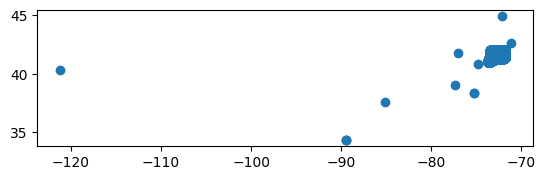

In [100]:
#Plot the data to see what it looks like
data2.plot()

<Axes: >

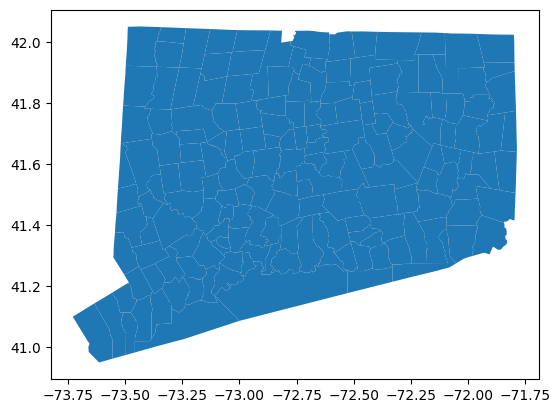

In [101]:
zshps.plot()

In [102]:
# Perform a spatial join and save dataframe as ckhomes
ckhomes = gp.sjoin(data2, zshps, how="inner", predicate ="within")

# Print the resulting GeoDataFrame
ckhomes

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location,geometry,index_right,GEOID,NAME
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,POINT (-73.06822 41.35014),POINT (-73.06822 41.35014),31,0900901220,Ansonia
14,2020108,2020,01/08/2021,Ansonia,145 PULASKI HWY,136100.0,269000.0,0.505900,Residential,Single Family,POINT (-73.04455 41.33126),POINT (-73.04455 41.33126),31,0900901220,Ansonia
104,2020038,2020,10/28/2020,Ansonia,121 ROCKWOOD AVE,126400.0,230000.0,0.549500,Residential,Single Family,POINT (-73.07174 41.35778),POINT (-73.07174 41.35778),31,0900901220,Ansonia
232,2020288,2020,07/27/2021,Ansonia,91 FOURTH ST UNIT 29,22100.0,70000.0,0.315714,Residential,Condo,POINT (-73.08112 41.35269),POINT (-73.08112 41.35269),31,0900901220,Ansonia
291,2020274,2020,07/09/2021,Ansonia,48 ROCKWOOD AVE,161500.0,372000.0,0.434100,Residential,Single Family,POINT (-73.07612 41.35426),POINT (-73.07612 41.35426),31,0900901220,Ansonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194067,19061,2019,09/29/2020,Voluntown,1 & 7 PRESTON CITY RD,153920.0,325000.0,0.473600,Residential,Single Family,POINT (-71.86215 41.57455),POINT (-71.86215 41.57455),169,0901178600,Voluntown
194521,19026,2019,03/30/2020,Voluntown,209 PENDLETON HILL RD,157090.0,280000.0,0.561000,Residential,Single Family,POINT (-71.85412 41.56218),POINT (-71.85412 41.56218),169,0901178600,Voluntown
195187,19006,2019,10/29/2019,Voluntown,106 MAIN ST,98410.0,170000.0,0.578900,Residential,Single Family,POINT (-71.86939 41.5729),POINT (-71.86939 41.57290),169,0901178600,Voluntown
196544,19046,2019,07/08/2020,Voluntown,385 WYLIE SCHOOL RD,150430.0,270000.0,0.557100,Residential,Single Family,POINT (-71.83148 41.60251),POINT (-71.83148 41.60251),169,0901178600,Voluntown


<Axes: >

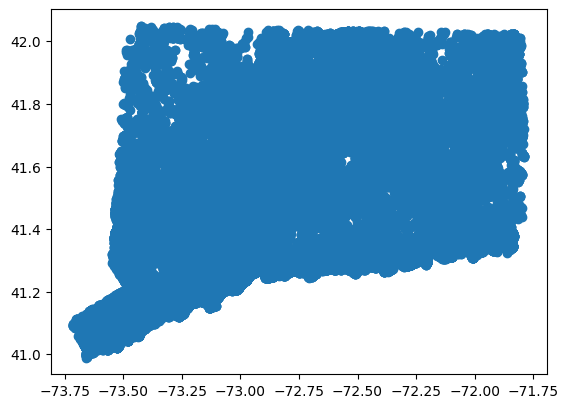

In [103]:
#Plot to see how it looks
ckhomes.plot()

**4. Data Analysis:**

The data analysis section will commence with fundamental descriptive and statistical analyses, followed by an exploration of the specific research questions aligned with the study's objectives.


In [104]:
# Summary statistics on the property types
Property_type_count= data["Property Type"].value_counts()
Property_type_count

Residential       608904
nan               382446
Vacant Land         3163
Commercial          1981
Apartments           486
Industrial           228
Public Utility         5
Name: Property Type, dtype: int64

The above result shows the frequency of sales for each property type between 2001 and 2020 with Residential Property types having the hightest number of sales.

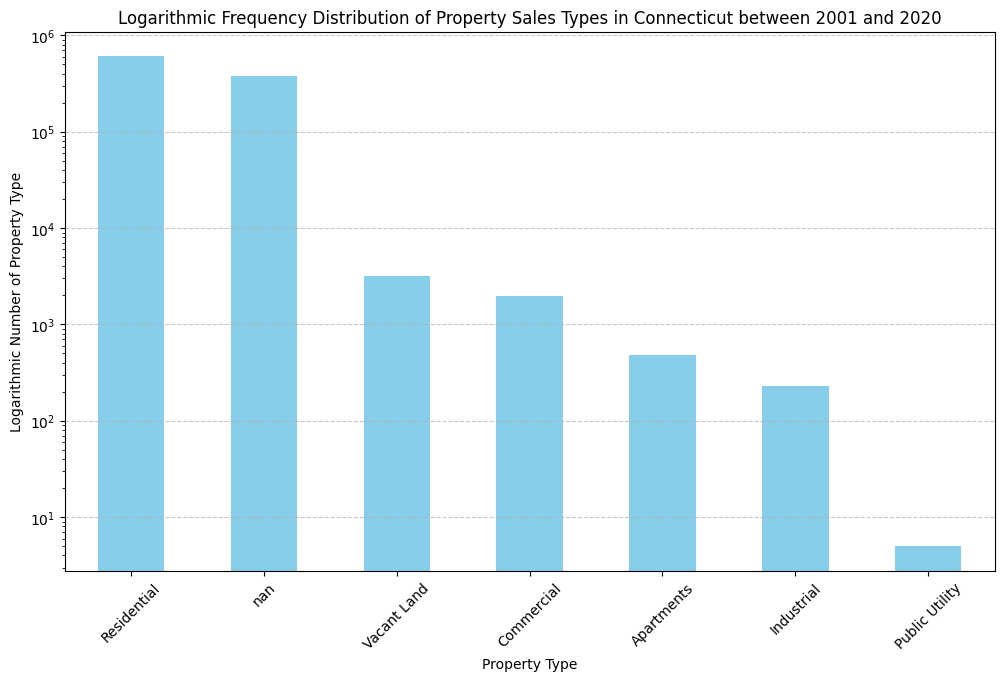

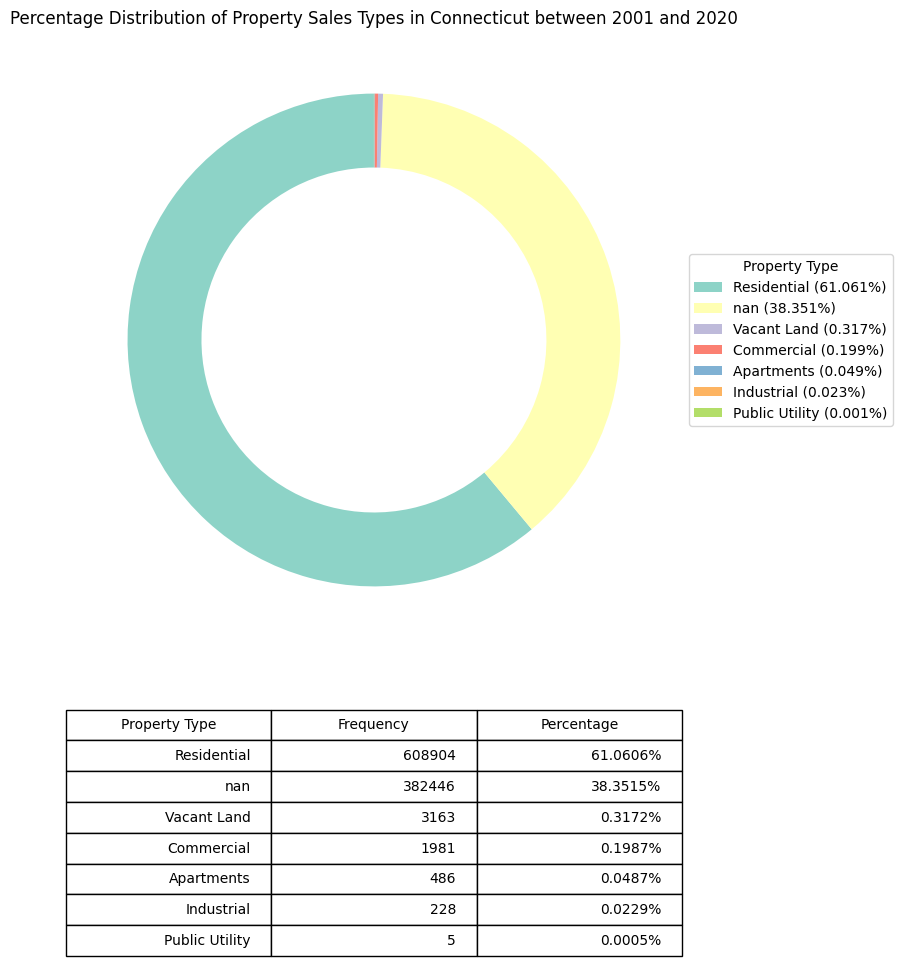

In [105]:
# -- Make a Barchart of the Property Types values
fig, ax = plt.subplots(figsize = (12,7))
Property_type_count.plot(kind= "bar", color ="skyblue", ax=ax)
ax.set_xlabel('Property Type')
ax.set_ylabel('Logarithmic Number of Property Type')
ax.set_title('Logarithmic Frequency Distribution of Property Sales Types in Connecticut between 2001 and 2020')
ax.set_yscale('log') # I am making a logarithmic scale for the Y axis so as to show the variations more clearly.
ax.tick_params(axis='x', rotation=45)
# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.show()

# Set a custom color palette for better distinction
custom_palette = sns.color_palette("Set3", len(Property_type_count))

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(Property_type_count, labels=Property_type_count.index, autopct='%1.1f%%',
                                  startangle=90, colors=custom_palette, wedgeprops=dict(width=0.3), textprops=dict(color="w"))

# Create legend with percentage values
legend_labels = [f'{label} ({percentage:.3f}%)' for label, percentage in zip(Property_type_count.index, Property_type_count / Property_type_count.sum() * 100)]
ax.legend(wedges, legend_labels, title="Property Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Create table for percentages and counts
table_data = list(zip(Property_type_count.index, Property_type_count, [f'{percentage:.4f}%' for percentage in Property_type_count / Property_type_count.sum() * 100]))
table_columns = ['Property Type', 'Frequency', 'Percentage']
table = ax.table(cellText=table_data, colLabels=table_columns, loc='bottom', bbox=[0, -0.5, 1, 0.4])

# Hide axes
ax.axis('off')

ax.set_title('Percentage Distribution of Property Sales Types in Connecticut between 2001 and 2020')
plt.show()

The plot above shows the frequency and percentage of sales for all property types between 2001 and 2020 with 61% of sales from Residential property types. The Nan percentage shows that 38% of the sales property type is not know which could include any property type. Sales of Vacant land covers 31% is jsut about 0.317% between 2001 and 2020.

+----------------+---------------+-----------+
| Property Type  |     Town      | Frequency |
+----------------+---------------+-----------+
|   Apartments   |   Hartford    |    122    |
|   Apartments   |   New Haven   |    52     |
|   Apartments   |  New Britain  |    42     |
|   Apartments   |   Waterbury   |    42     |
|   Apartments   |   Stratford   |    35     |
|   Commercial   |   Stamford    |    139    |
|   Commercial   |   Hartford    |    102    |
|   Commercial   |   Waterbury   |    97     |
|   Commercial   |   New Haven   |    65     |
|   Commercial   |    Norwalk    |    53     |
|   Industrial   | South Windsor |    24     |
|   Industrial   |  Bloomfield   |    19     |
|   Industrial   |    Danbury    |    10     |
|   Industrial   | West Hartford |    10     |
|   Industrial   |  Brookfield   |     8     |
| Public Utility |    Granby     |     1     |
| Public Utility |   Griswold    |     1     |
| Public Utility |  Plainfield   |     1     |
| Public Util

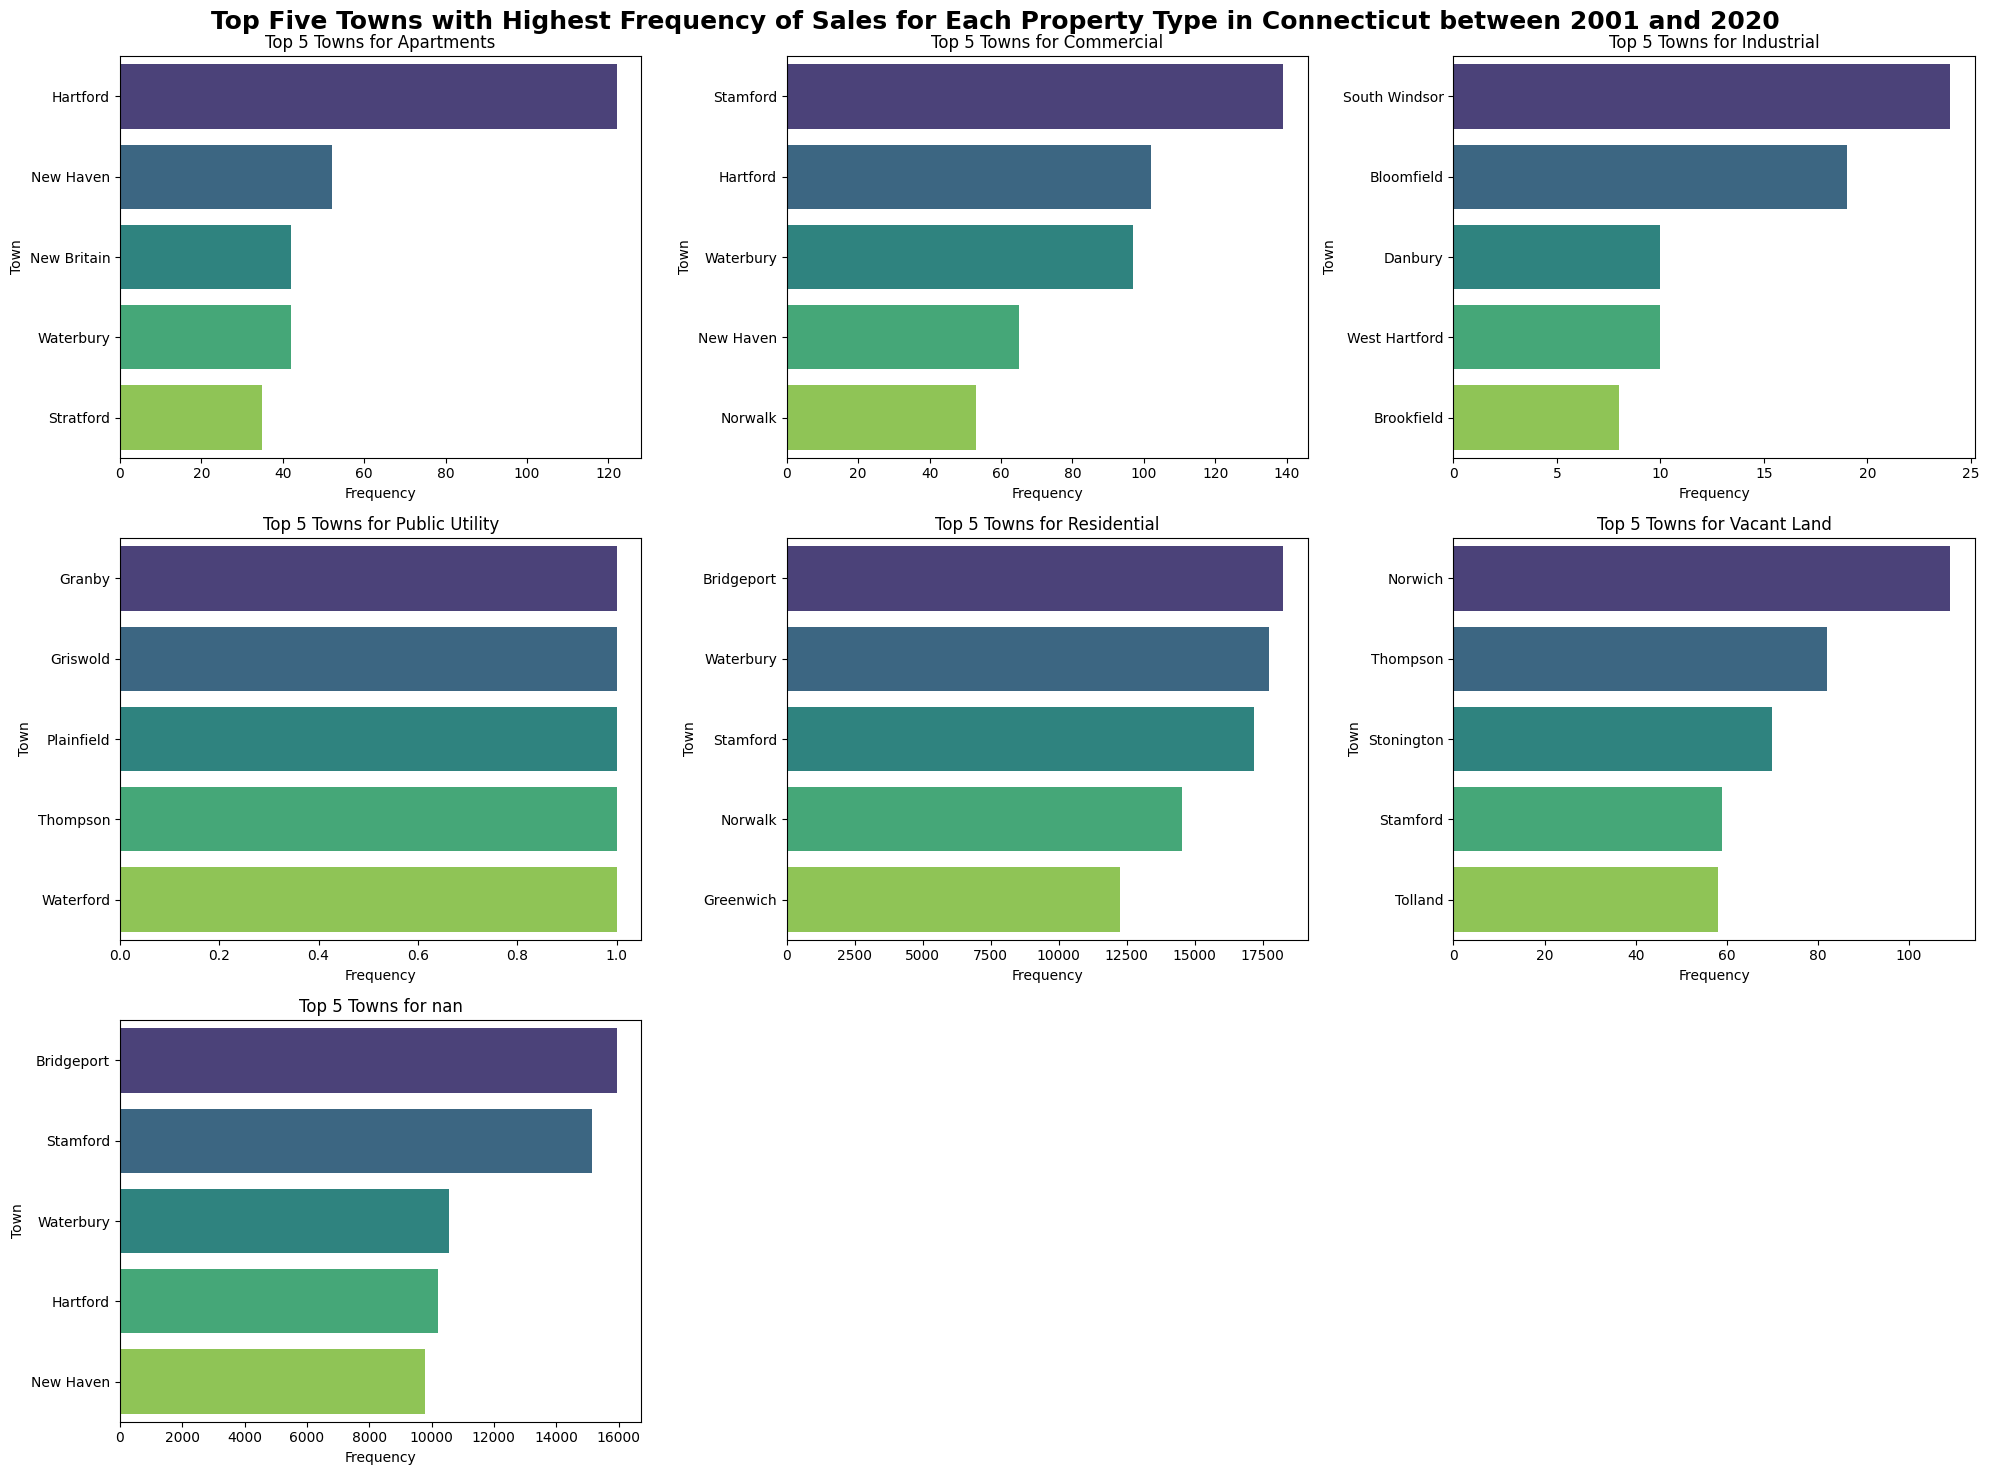

In [106]:
from tabulate import tabulate

# Print the top 5 towns with the highest frequency for each Property Type
# Group by 'Property Type' and 'Town' and count the frequency
town_counts = data.groupby(['Property Type', 'Town']).size().reset_index(name='Frequency')

# Sort the DataFrame by frequency in descending order
town_counts_sorted = town_counts.sort_values(by=['Property Type', 'Frequency'], ascending=[True, False])

# Get the top three towns for each property type
top_towns_by_type = town_counts_sorted.groupby('Property Type').head(5)

# Print the result in tabular form
print(tabulate(top_towns_by_type, headers='keys', tablefmt='pretty', showindex=False))

# Plot bar charts for each property type
plt.figure(figsize=(20, 15))
for i, property_type in enumerate(top_towns_by_type['Property Type'].unique(), 1):
    plt.subplot(3, 3, i)  # Adjust the subplot grid based on the number of property types
    property_type_data = top_towns_by_type[top_towns_by_type['Property Type'] == property_type]
    sns.barplot(x='Frequency', y='Town', data=property_type_data, palette='viridis')
    plt.title(f'Top 5 Towns for {property_type}')
    plt.xlabel('Frequency')
    plt.ylabel('Town')

# Add the main title
plt.suptitle("Top Five Towns with Highest Frequency of Sales for Each Property Type in Connecticut between 2001 and 2020", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

The plot shows the top five towns in Connecticut with the highest number of sales accross each property type. We can deduce that Bridgeport has the highest number of slaes of residential properties while  Hartford has the highest sales for Apartments. For the commercial properties, the highest frequecny of sales so far was recorded in Stamford while South Windsor has the highest frequency of sales for Industrial buildings.

In [107]:
# Summary statistics on the residential types
Residential_type_count= data["Residential Type"].value_counts()
Residential_type_count

Single Family    445016
Condo            117780
Two Family        29609
Three Family      14081
Four Family        2418
Name: Residential Type, dtype: int64

The  result above shows a summary on the frequency of sales accross each residential property type between 2001 and 2020 in Connecticut USA

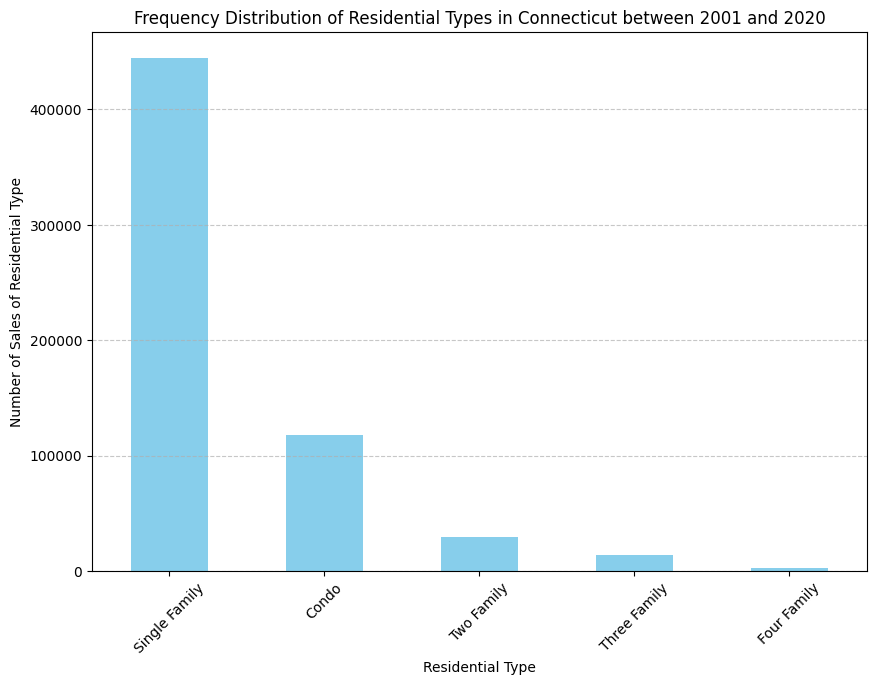

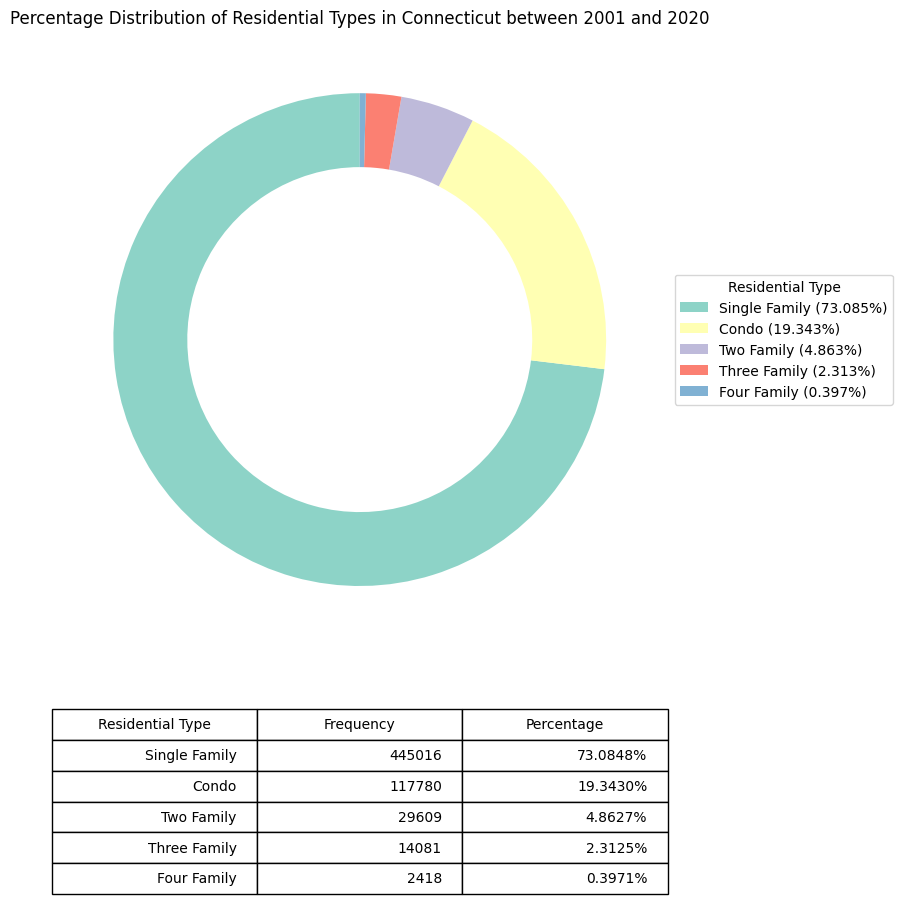

In [108]:
# -- make a barchart showing the frequency of the Residential Types
fig, ax = plt.subplots(figsize = (10,7))
Residential_type_count.plot(kind= "bar", color ="skyblue", ax=ax)
ax.set_xlabel('Residential Type')
ax.set_ylabel('Number of Sales of Residential Type')
ax.set_title('Frequency Distribution of Residential Types in Connecticut between 2001 and 2020')
ax.tick_params(axis='x', rotation=45)
# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.show()

# Set a custom color palette for better distinction
custom_palette = sns.color_palette("Set3", len(Residential_type_count))

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(Residential_type_count, labels=Residential_type_count.index, autopct='%1.1f%%',
                                  startangle=90, colors=custom_palette, wedgeprops=dict(width=0.3), textprops=dict(color="w"))

# Create legend with percentage values
legend_labels = [f'{label} ({percentage:.3f}%)' for label, percentage in zip(Residential_type_count.index, Residential_type_count / Residential_type_count.sum() * 100)]
ax.legend(wedges, legend_labels, title="Residential Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Create table for percentages and counts
table_data = list(zip(Residential_type_count.index, Residential_type_count, [f'{percentage:.4f}%' for percentage in Residential_type_count / Residential_type_count.sum() * 100]))
table_columns = ['Residential Type', 'Frequency', 'Percentage']
table = ax.table(cellText=table_data, colLabels=table_columns, loc='bottom', bbox=[0, -0.4, 1, 0.3])

# Hide axes
ax.axis('off')

ax.set_title('Percentage Distribution of Residential Types in Connecticut between 2001 and 2020')
plt.show()

The plot above shows the frequency and percentage of sales for all residential property types between 2001 and 2020 with 73% of sales from Single family Residential property types followed by the Condo residential property type which is 19.34%. This implies that individual preferences for residential property tends more towards having their private space as much as possibile.

+------------------+---------------+-----------+
| Residential Type |     Town      | Frequency |
+------------------+---------------+-----------+
|      Condo       |   Stamford    |   7440    |
|      Condo       |    Danbury    |   5373    |
|      Condo       |    Norwalk    |   5025    |
|      Condo       |  Bridgeport   |   3999    |
|      Condo       |   Waterbury   |   3256    |
|   Four Family    |  Bridgeport   |    312    |
|   Four Family    |   Waterbury   |    262    |
|   Four Family    |   New Haven   |    235    |
|   Four Family    |    Norwich    |    123    |
|   Four Family    |  New Britain  |    112    |
|  Single Family   |   Waterbury   |   10508   |
|  Single Family   | West Hartford |   9583    |
|  Single Family   |   Fairfield   |   9531    |
|  Single Family   |   Greenwich   |   9254    |
|  Single Family   |   Stamford    |   8674    |
|   Three Family   |  Bridgeport   |   2087    |
|   Three Family   |   Waterbury   |   2056    |
|   Three Family   |

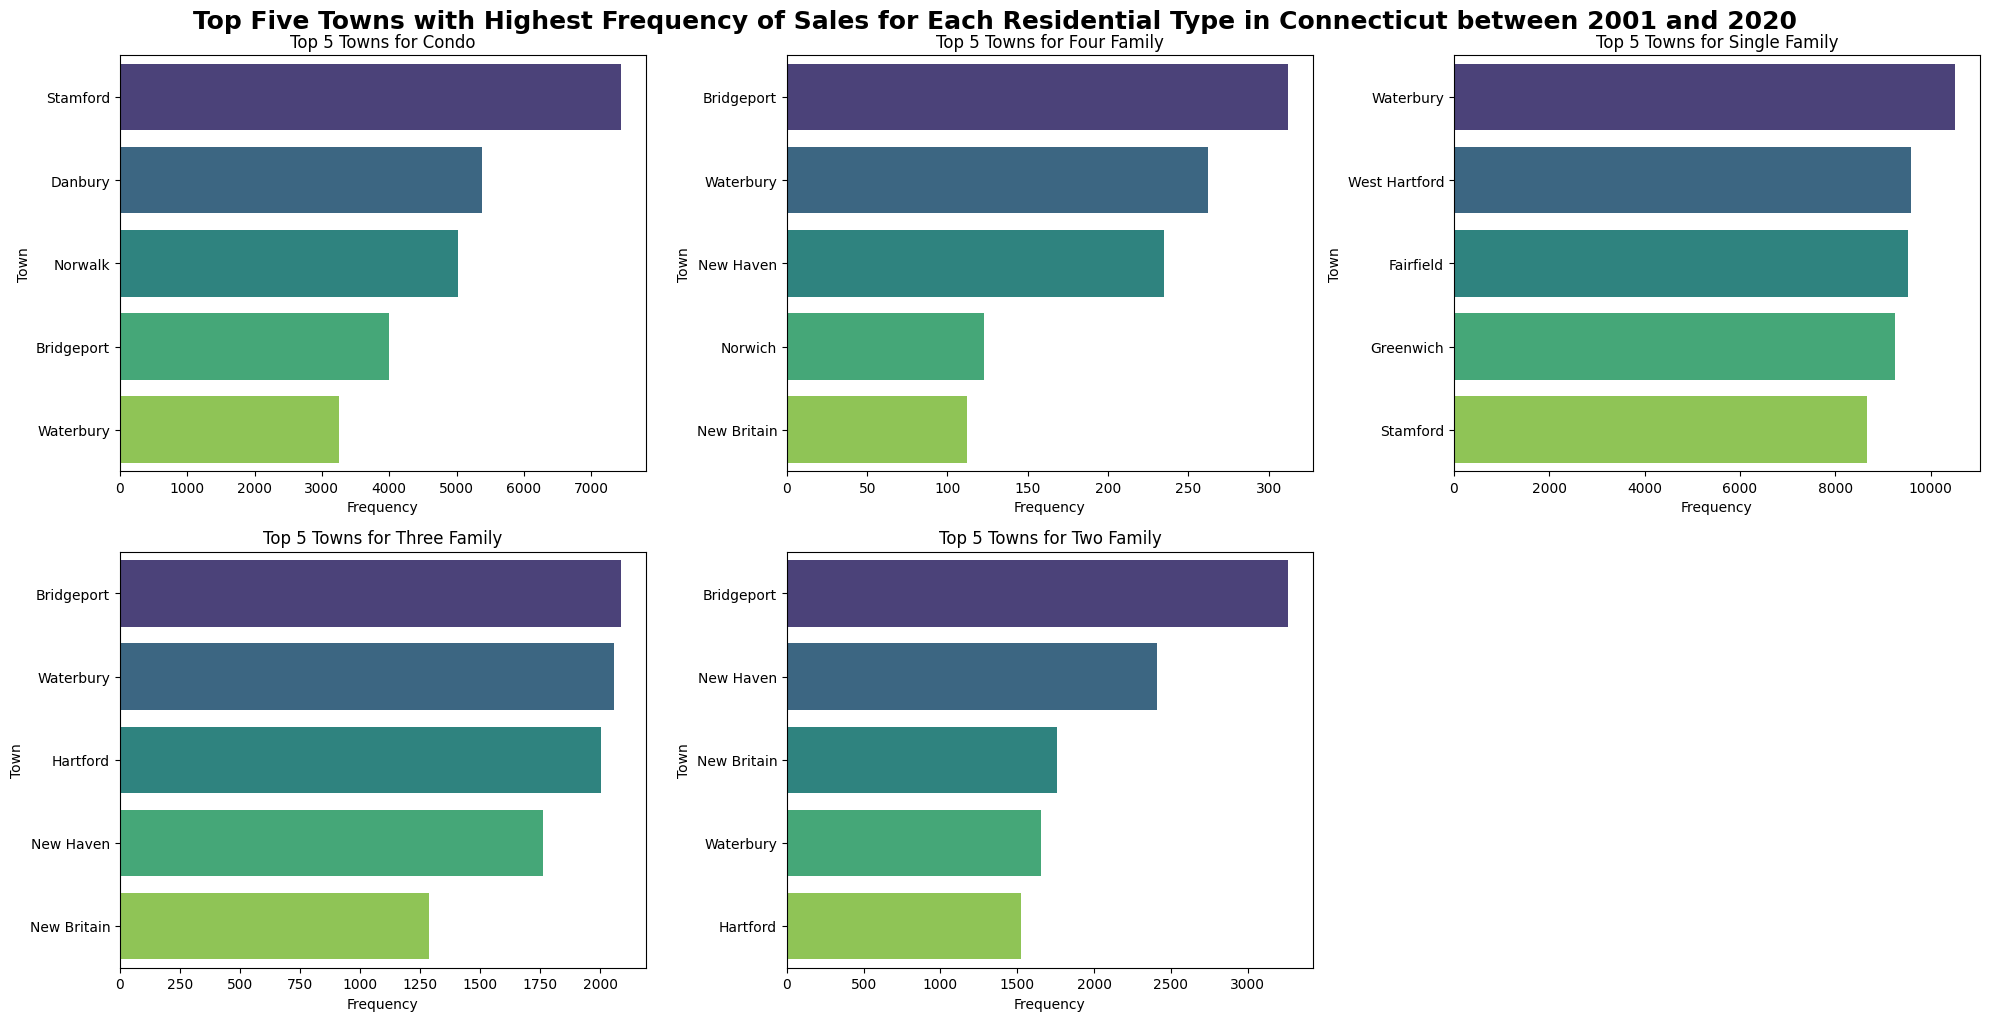

In [109]:
# Print the top 5 towns with the highest frequency for each Residential Type
# Group by 'Residential Type' and 'Town' and count the frequency
town_counts = data.groupby(['Residential Type', 'Town']).size().reset_index(name='Frequency')

# Sort the DataFrame by frequency in descending order
town_counts_sorted = town_counts.sort_values(by=['Residential Type', 'Frequency'], ascending=[True, False])

# Get the top three towns for each Residential type
top_towns_by_type = town_counts_sorted.groupby('Residential Type').head(5)

# Print the result in tabular form
print(tabulate(top_towns_by_type, headers='keys', tablefmt='pretty', showindex=False))

# Plot bar charts for each Residential type
plt.figure(figsize=(20, 15))
for i, ck in enumerate(top_towns_by_type['Residential Type'].unique(), 1):
    plt.subplot(3, 3, i)  # Adjust the subplot grid based on the number of Residential types
    residential_type_data = top_towns_by_type[top_towns_by_type['Residential Type'] == ck]
    sns.barplot(x='Frequency', y='Town', data=residential_type_data, palette='viridis')
    plt.title(f'Top 5 Towns for {ck}')
    plt.xlabel('Frequency')
    plt.ylabel('Town')

# Add the main title
plt.suptitle("Top Five Towns with Highest Frequency of Sales for Each Residential Type in Connecticut between 2001 and 2020", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

The plot and table above shows the top five towns with the highest number of sales accross each residential property type between 2001 and 2020. The result shows that Waterbury has the number of sales for Single Family houses followed by West Hartford. Also it reveals that Bridgeport has the highest frequency of sales for Two, Three and Four family houses while Stamford has the highest frequency of sales for Condo houses.


**Question 1:**

"How do sales prices vary across different property types (residential, apartment, commercial, industrial, and vacant land) in Connecticut?"


In [110]:
#sales summary according to Property Type
Property_sales_summary = data.groupby('Property Type')['Sale Amount'].describe()
Property_sales_summary

,count,mean,std,min,25%,50%,75%,max
Property Type,,,,,,,,
Apartments,486.0,1.283431e+07,2.268757e+08,20000.0,266250.0,400000.0,931243.75,5.000000e+09
Commercial,1981.0,1.788884e+06,7.436385e+06,4500.0,187000.0,400000.0,1000000.00,1.540000e+08
Industrial,228.0,2.004287e+06,4.990531e+06,15000.0,235000.0,645000.0,1751250.00,5.000000e+07
Public Utility,5.0,3.697088e+05,5.878167e+05,34594.0,39000.0,59950.0,315000.00,1.400000e+06
Residential,608904.0,3.625685e+05,9.414844e+05,0.0,150000.0,235000.0,370000.00,3.187900e+08
Vacant Land,3163.0,2.957016e+05,9.746138e+05,2000.0,41000.0,100000.0,235000.00,3.675000e+07
nan,382446.0,4.134342e+05,2.711139e+06,0.0,125000.0,207000.0,350000.00,3.955000e+08


In [111]:
#sales summary according to Residential Type
Residential_sales_summary = data.groupby('Residential Type')['Sale Amount'].describe()
Residential_sales_summary

,count,mean,std,min,25%,50%,75%,max
Residential Type,,,,,,,,
Condo,117780.0,277243.999864,1.223231e+06,0.0,115000.0,177000.0,290000.0,72000000.0
Four Family,2418.0,314931.857734,3.206228e+06,0.0,113075.0,200000.0,300000.0,157000000.0
Single Family,445016.0,400790.313557,8.158536e+05,0.0,170000.0,259000.0,407000.0,318790019.0
Three Family,14081.0,203695.502356,1.643183e+06,1671.0,89500.0,165000.0,249000.0,194149073.0
Two Family,29609.0,206955.765369,2.490829e+05,0.0,100000.0,170000.0,250000.0,17900000.0


The results above shows the summary statistics for the Property types and Residential properties, proving insight on the maximum, minimum and other statistics for the sales price accross different building types between 2001 and 2020. The most expensive sales price is $5000000000 for an apartment property type which is unknown at the moment. Join me as we dive further into the analysis.


In [112]:
import plotly.graph_objects as go
# Calculate average sales prices by property type
avg_price_by_type = data.groupby('Property Type')['Sale Amount'].mean().sort_values(ascending=False)

# Round the values to two decimal places
avg_price_by_type = avg_price_by_type.round(2)

# Print the result in a table
avg_price_table = pd.DataFrame({'Property Type': avg_price_by_type.index, 'Average Sale Amount': avg_price_by_type.values})
# avg_price_table

# Add the '$' symbol to the text for the callouts
avg_price_table['Average_Sales_Price'] = '$' + avg_price_table['Average Sale Amount'].astype(str)

# Print the result in a table using Plotly
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Property Type', 'Average Sale Amount [$ USD]']),
    cells=dict(values=[avg_price_by_type.index, avg_price_by_type.values]))
])
table_fig.update_layout(width=600, height=500)
table_fig.show()

# Plot an interactive bar chart with Plotly
fig = px.bar(avg_price_table, x='Property Type', y='Average Sale Amount', title='Average Sales Prices Across Property Types in Connecticut between 2001 and 2020',
             labels={'Average Sale Amount': 'Average Sale Amount [$]'},
             color='Average Sale Amount', color_continuous_scale='viridis',
             hover_data={'Average_Sales_Price': True})  # Use hover_data to display the Average_Sales_Price in callouts
fig.update_layout(xaxis={'categoryorder':'total descending'}, xaxis_title='Property Type', yaxis_title='Average Sale Amount [$ USD]')
# Adjust width and height
fig.update_layout(width=1000, height=800)
fig.show()

The result above shows that the Apartments Property types has the highest avearage sales price btween 2001 and 2020, which is $12,834,306.99 and followed by the Industrial property type. Also taking into account the frequency of Apartment property types, we can see cleary that the sales price are on the highside compared to the residential property type which has the highest frequency of sales accross the years.

In [113]:
# # Bar chart comparing average sales prices across Residential types

# Calculate average sales prices by Residential type
avg_price_by_type = data.groupby('Residential Type')['Sale Amount'].mean().sort_values(ascending=False)

# Round the values to two decimal places
avg_price_by_type = avg_price_by_type.round(2)

# Print the result in a table
avg_price_table = pd.DataFrame({'Residential Type': avg_price_by_type.index, 'Average Sale Amount': avg_price_by_type.values})
# avg_price_table

# Add the '$' symbol to the text for the callouts
avg_price_table['Average_Sales_Price'] = '$' + avg_price_table['Average Sale Amount'].astype(str)

# Print the result in a table using Plotly
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Residential Type', 'Average Sale Amount [$ USD]']),
    cells=dict(values=[avg_price_by_type.index, avg_price_by_type.values]))
])
table_fig.update_layout(width=600, height=500)
table_fig.show()

# Plot an interactive bar chart with Plotly
fig = px.bar(avg_price_table, x='Residential Type', y='Average Sale Amount', title='Average Sales Prices Across Residential Types in Connecticut between 2001 and 2020',
             labels={'Average Sale Amount': 'Average Sale Amount [$]'},
             color='Average Sale Amount', color_continuous_scale='viridis',
             hover_data={'Average_Sales_Price': True})  # Use hover_data to display the Average_Sales_Price in callouts
fig.update_layout(xaxis={'categoryorder':'total descending'}, xaxis_title='Residential Type', yaxis_title='Average Sale Amount [$ USD]')
# Adjust width and height
fig.update_layout(width=1000, height=800)
fig.show()

The chart above reveals the average sales price accross all residential property type with the single family houses having the hightest mean sales price of $400790 followed by the Four family residential property type.

In [114]:
# Printing out the Towns with the hightest sales prices for Property Types
top_towns = data.groupby(['Property Type', 'Town'])['Sale Amount'].mean().reset_index()
top_towns = top_towns.sort_values(by=['Property Type', 'Sale Amount'], ascending=[True, False])

# Select the top 5 towns for each property type
top_towns = top_towns.groupby('Property Type').head(5)
print("The top 5 towns with the highest average sales price accross each of the property types are as below")
print(top_towns)

# Create separate bar plots for each property type
for property_type in top_towns['Property Type'].unique():
    property_type_data = top_towns[top_towns['Property Type'] == property_type]

    # Bar plot
    fig = px.bar(property_type_data, x='Sale Amount', y='Town', orientation='h',
                 title=f'Top 5 Towns with Highest Sale Prices for {property_type} Property in Connecticut between 2001 and 2020',
                 labels={'Sale Amount': 'Mean Sale Amount', 'Town': 'Town'},
                 color_discrete_sequence=px.colors.qualitative.Set1)
    # Adjust layout
    fig.update_layout(legend_title='Property Type', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
                      height=400, width=1200)
    # Show plot
    fig.show()

The top 5 towns with the highest average sales price accross each of the property types are as below
      Property Type           Town   Sale Amount
48       Apartments     Willington  5.000000e+09
42       Apartments       Trumbull  8.200000e+07
51       Apartments        Windsor  4.209333e+07
49       Apartments         Wilton  3.475000e+07
32       Apartments        Norwalk  2.522512e+07
151      Commercial       Stamford  7.190861e+06
79       Commercial       Cromwell  6.291901e+06
168      Commercial  West Hartford  5.149194e+06
130      Commercial        Norwalk  4.425167e+06
172      Commercial         Wilton  4.333568e+06
229      Industrial  South Windsor  6.525725e+06
193      Industrial       Cheshire  5.963472e+06
211      Industrial        Meriden  5.698000e+06
201      Industrial       Eastford  5.100000e+06
195      Industrial        Danbury  4.409500e+06
248  Public Utility       Griswold  1.400000e+06
247  Public Utility         Granby  3.150000e+05
250  Public Utili

The result above shows the top 5 towns with highest average sales price for each of the of the property types. It reveals that Willington, Stamford, South Windsor, Griswold, Greenwich and Greenwich have the highest average sales price for Apartments, Commercial, Industrial, Public utility, Residential and Vacnat Land respectively. Also, we can see that Greenwich has the average sales prices for missing values which implies there is potential for high average sales price in this town.

In [115]:
# Printing out the Towns with the hightest sales prices for Residential Types
top_towns = data.groupby(['Residential Type', 'Town'])['Sale Amount'].mean().reset_index()
top_towns = top_towns.sort_values(by=['Residential Type', 'Sale Amount'], ascending=[True, False])

# Select the top 5 towns for each Residential type
top_towns = top_towns.groupby('Residential Type').head(5)
print("The top 5 towns with the highest average sales price accross each of the residential types are as below")
print(top_towns)

# Create separate bar plots for each residential type
for ck in top_towns['Residential Type'].unique():
    presidential_type_data = top_towns[top_towns['Residential Type'] == ck]

    # Bar plot
    fig = px.bar(property_type_data, x='Sale Amount', y='Town', orientation='h',
                 title=f'Top 5 Towns with Highest Sale Prices for {ck} Residential Property in Connecticut between 2001 and 2020',
                 labels={'Sale Amount': 'Mean Sale Amount', 'Town': 'Town'},
                 color_discrete_sequence=px.colors.qualitative.Set1)
    # Adjust layout
    fig.update_layout(legend_title='Property Type', legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
                      height=400, width=1200)
    # Show plot
    fig.show()

The top 5 towns with the highest average sales price accross each of the residential types are as below
    Residential Type              Town   Sale Amount
110            Condo        Rocky Hill  1.267478e+06
29             Condo            Darien  9.965579e+05
50             Condo         Greenwich  9.865777e+05
81             Condo        New Canaan  7.426905e+05
144            Condo            Weston  7.029545e+05
216      Four Family         Newington  4.500000e+06
219      Four Family           Norwalk  4.299429e+06
191      Four Family         Greenwich  1.636750e+06
164      Four Family        Brookfield  1.000000e+06
204      Four Family        Middlebury  9.250000e+05
323    Single Family         Greenwich  2.438219e+06
356    Single Family        New Canaan  1.712670e+06
301    Single Family            Darien  1.646121e+06
424    Single Family          Westport  1.440803e+06
416    Single Family        Washington  9.924859e+05
554     Three Family        Willington  6.480136

The result above shows that Greenwich has the highest average sales price for all residential property types and it is worthy of much more exploration as to why the residential properties in that location are more expensive compared to other towns.

In [116]:
#To classify the towns according to how expensive the property types are

# Group by Town and Property Type, calculate the mean cost
town_property_mean = data.groupby(['Town', 'Property Type'])['Sale Amount'].mean().reset_index()

# Pivot the table to get Property Types as columns
town_property_pivot = town_property_mean.pivot(index='Town', columns='Property Type', values='Sale Amount')

# Classify towns according to property type with maximum mean cost
town_classification = town_property_pivot.idxmax(axis=1)
town_classification_df = pd.DataFrame({'Town': town_classification.index, 'Expensive_Property_Type': town_classification.values})

# Display the resulting DataFrame
town_classification_df

,Town,Expensive_Property_Type
0,***Unknown***,Residential
1,Andover,Residential
2,Ansonia,Industrial
3,Ashford,Apartments
4,Avon,Commercial
...,...,...
165,Windsor Locks,Apartments
166,Wolcott,Commercial
167,Woodbridge,Commercial
168,Woodbury,Apartments


In [117]:
# Using the 'Town' column which is the common column in both DataFrames
exp_properties = pd.merge(zshps, town_classification_df, how='left', left_on='NAME', right_on='Town')
# Create a new GeoDataFrame with the geometry, town name, and property type
choropleth_gdf = gp.GeoDataFrame(exp_properties[['geometry', 'Town', 'Expensive_Property_Type']]).set_index('Town')

# Create an interactive choropleth map
fig = px.choropleth_mapbox(choropleth_gdf,
                           geojson=choropleth_gdf.geometry.__geo_interface__,
                           locations=choropleth_gdf.index,
                           color='Expensive_Property_Type',
                           hover_data={'Expensive_Property_Type': True},  # Add 'Town' to hover data
                           color_discrete_sequence=px.colors.sequential.Viridis,
                           mapbox_style="carto-positron",
                           zoom=8, center={"lat": 41.5, "lon": -72.7})
# Add a title to the plot
fig.update_layout(title_text='Top Property Type with Highest Sale Amount in Each Town in Connecticut between 2001 and 2020')

# Show the plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

The results above classifies all the towns in Connecticut based on the most expensive property type in the town based on the analysis we have done so far. The same is going to be repeated for the residential property types below.

In [118]:
#To classify the towns according to how expensive the property types are

# Group by Town and Property Type, calculate the mean cost
town_residential_mean = data.groupby(['Town', 'Residential Type'])['Sale Amount'].mean().reset_index()

# Pivot the table to get Property Types as columns
town_residential_pivot = town_residential_mean.pivot(index='Town', columns='Residential Type', values='Sale Amount')

# Classify towns according to property type with maximum mean cost
town_classification = town_residential_pivot.idxmax(axis=1)
town_classification_df = pd.DataFrame({'Town': town_classification.index, 'Expensive_Residential_Type': town_classification.values})

# Display the resulting DataFrame
town_classification_df

# Using the 'Town' column which is the common column in both DataFrames
exp_residences = pd.merge(zshps, town_classification_df, how='left', left_on='NAME', right_on='Town')
# Create a new GeoDataFrame with the geometry, town name, and property type
choropleth_gdf = gp.GeoDataFrame(exp_residences[['geometry', 'Town', 'Expensive_Residential_Type']]).set_index('Town')

# Create an interactive choropleth map
fig = px.choropleth_mapbox(choropleth_gdf,
                           geojson=choropleth_gdf.geometry.__geo_interface__,
                           locations=choropleth_gdf.index,
                           color='Expensive_Residential_Type',
                           hover_data={'Expensive_Residential_Type': True},  # Add 'Town' to hover data
                           color_discrete_sequence=px.colors.sequential.Viridis,
                           mapbox_style="carto-positron",
                           zoom=8, center={"lat": 41.5, "lon": -72.7})
# Add a title to the plot
fig.update_layout(title_text='Top Residential Property Type with Highest Sale Amount in Each Town in Connecticut between 2001 and 2020')


# Show the plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

The next section shows result of a dashboard for each of the property types and residential property type. It shows the location of the property types and also shows the prices for the property or residential type.

In [119]:
!pip install dash

In [120]:
from dash import Dash, dcc, html, Input, Output

# Initialize Dash app
app = Dash()

# Define the layout
app.layout = html.Div([
    html.H1("Welcome to CK Homes and Properties LTD"),
    html.H1("Sales Prices for Different Property Types in Connecticut between 2001 and 2020"),
    html.Div(html.P("You are presented with sales prices for all property and residential types across Connecticut. Please select as applicable")),

    # Radio buttons for property types (arranged horizontally)
    dcc.RadioItems(
        id='property-type-selector',
        options=[
            {'label': 'Residential', 'value': 'Residential'},
            {'label': 'Commercial', 'value': 'Commercial'},
            {'label': 'Vacant Land', 'value': 'Vacant Land'},
            {'label': 'Apartments', 'value': 'Apartments'},
            {'label': 'Industrial', 'value': 'Industrial'},
            {'label': 'Public Utility', 'value': 'Public Utility'},
            {'label': 'Condo', 'value': 'Condo'},
            {'label': 'Four Family', 'value': 'Four Family'},
            {'label': 'Single Family', 'value': 'Single Family'},
            {'label': 'Three Family', 'value': 'Three Family'},
            {'label': 'All Properties', 'value': 'Total'}
        ],
        value='Residential',  # Default selected value
        labelStyle={'display': 'inline-block', 'margin-right': '10px'}  # Display options horizontally
    ),

    # Graph to display sales prices
    dcc.Graph(id='sales-price-plot')
])

# Define callback to update the graph based on the selected property type
@app.callback(
    Output('sales-price-plot', 'figure'),
    Input('property-type-selector', 'value')
)
def update_sales_price_plot(selected_property_type):
    if selected_property_type == 'Total':
        fig = px.scatter_mapbox(ckhomes,
                        lat=ckhomes['geometry'].y, lon=ckhomes['geometry'].x,
                        color='Sale Amount', size='Sale Amount',
                        hover_name='Address',
                        mapbox_style="carto-positron", zoom=6)
        fig.update_layout(title='Scatter Plot of Property Locations with Sales Amount')
    else:
        if selected_property_type in ['Condo', 'Four Family', 'Single Family', 'Three Family']:
            ckhome = ckhomes[ckhomes['Residential Type'] == selected_property_type]
        else:
            ckhome = ckhomes[ckhomes['Property Type'] == selected_property_type]

        fig = px.scatter_mapbox(ckhome,
                        lat=ckhome['geometry'].y, lon=ckhome['geometry'].x,
                        color='Sale Amount', size='Sale Amount',
                        hover_name='Address',
                        mapbox_style="open-street-map", zoom=9)
        fig.update_layout(title='Scatter Plot of Property Locations with Sales Amount')

    return fig

# Run the app
app.run_server()

<IPython.core.display.Javascript object>

In [121]:
fig = px.scatter_mapbox(ckhomes,
                        lat=ckhomes['geometry'].y, lon=ckhomes['geometry'].x,
                        color='Sale Amount', size='Sale Amount',
                        hover_name='Address',
                        mapbox_style="carto-positron", zoom=8)
fig.update_layout(title='Scatter Plot of All Property Locations with Sales Amount')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

**Question 2**: Is there a correlation between property assessment values and actual sales prices for real estate transactions in Connecticut?"

**"Correlation Analysis: Exploring the Relationship Between Variables in the DataFrame"**


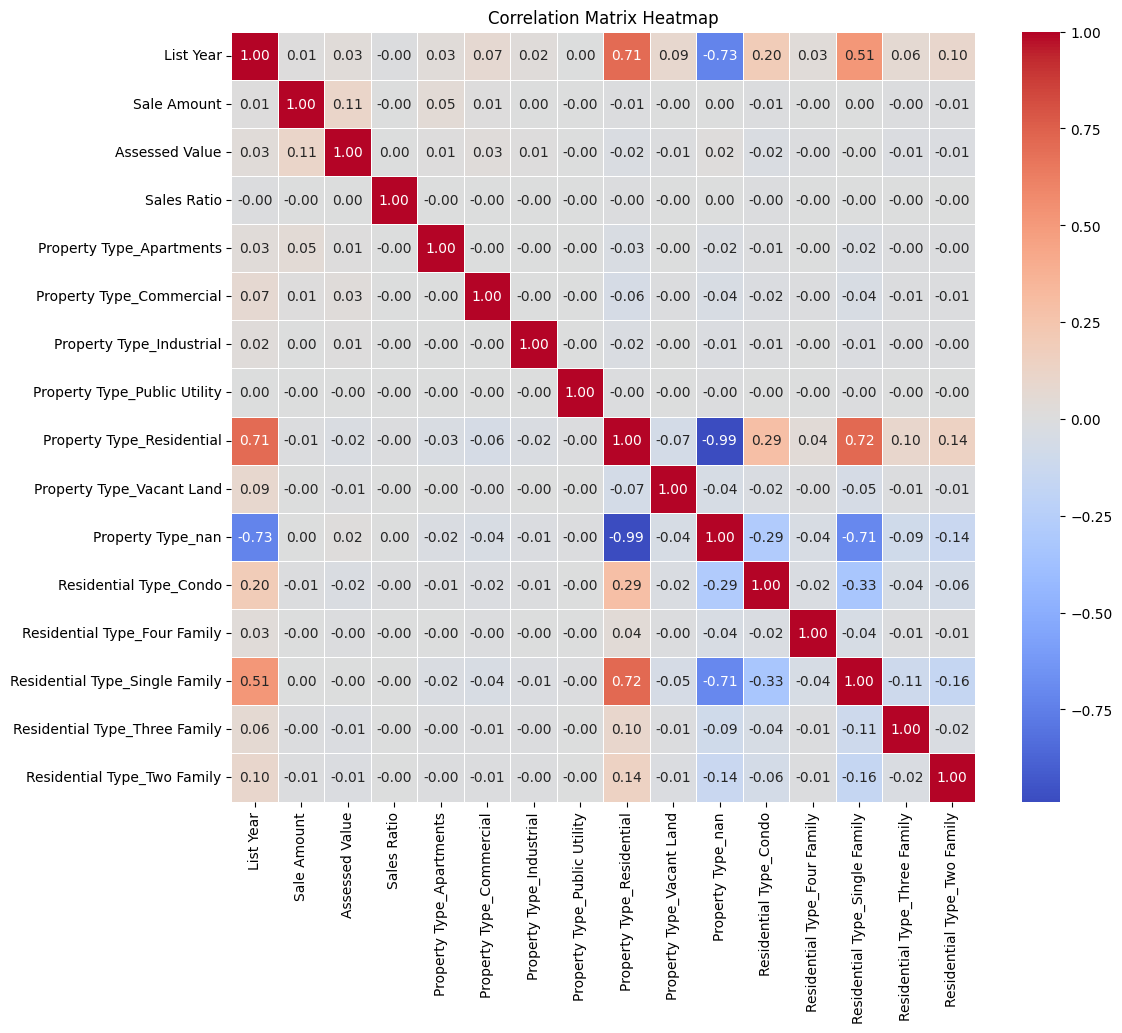

In [122]:
import seaborn as sns

# Drop any rows with missing values in the columns of interest
data_numeric = data[['List Year', 'Sale Amount', 'Assessed Value', 'Sales Ratio']]

# One-hot encode categorical variables (Property Type and Residential Type)
data_encoded = pd.get_dummies(data[['Property Type', 'Residential Type']])

# Concatenate numeric and encoded categorical variables
data_combined = pd.concat([data_numeric, data_encoded], axis=1)

# Calculate correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.6)
plt.title('Correlation Matrix Heatmap')
plt.show()


"The correlation coefficient of 0.71 between Residential property type and List Year indicates a notable positive association. As we look at the dataset, it suggests that, over the years, there has been a tendency for an increase in the number or occurrence of residential properties. This positive correlation could be due to various factors such as population growth, urban development trends, or changes in housing preferences over time."

**Question 3:** "What are the trends in real estate sales prices over the years, considering the annual reporting cycle from October 1 to September 30?"


In [123]:
# Group by property type and year and calculate the mean sale amount
annual_avg_prices = data.groupby(['Property Type', 'List Year'])['Sale Amount'].mean().reset_index()


# Get unique property types
property_types = annual_avg_prices['Property Type'].unique()

# Create a separate line plot for each property type using a loop
for property_type in property_types:
    subset_data = annual_avg_prices[annual_avg_prices['Property Type'] == property_type]
   # Check if there is more than one row of data
    if len(subset_data) > 1:
        fig = px.line(subset_data, x='List Year', y='Sale Amount',
                      labels={'Sale Amount': 'Average Annual Sale Amount'},
                      title=f'Average Annual Sales Prices for {property_type} (2001-2020)',
                      template='plotly_dark')
    else:
        fig = px.scatter(subset_data, x='List Year', y='Sale Amount',
                         labels={'Sale Amount': 'Average Annual Sale Amount'},
                         title=f'Average Annual Sales Prices for {property_type} (2001-2020)',
                         template='plotly_dark')

    # Show the plot
    fig.show()

In [124]:
property_avg_prices = data.groupby(['List Year', 'Property Type'])['Sale Amount'].mean().reset_index()

# Extract the minimum and maximum years
min_year = property_avg_prices['List Year'].min()
max_year = property_avg_prices['List Year'].max()

# Make a line plot
fig = px.line(property_avg_prices, x='List Year', y='Sale Amount', color='Property Type',
              title='Average Annual Sales Prices for Property Types (2001-2020)',
              labels={'List Year': 'Year', 'Sale Amount': 'Average Sale Amount [$]'},
              range_x=[min_year, max_year])

# Show the plot
fig.show()

In [125]:
# Group by property type and year and calculate the mean sale amount
annual_avg_prices = data.groupby(['Residential Type', 'List Year'])['Sale Amount'].mean().reset_index()


# Get unique property types
residential_types = annual_avg_prices['Residential Type'].unique()

# Create a separate line plot for each property type using a loop
for resi_type in residential_types:
    subset_data = annual_avg_prices[annual_avg_prices['Residential Type'] == resi_type]

    fig = px.line(subset_data, x='List Year', y='Sale Amount',
                  labels={'Sale Amount': 'Average Annual Sale Amount [$]', 'List Year': 'Year'},
                  title=f'Average Annual Sales Prices for {resi_type} Residential Property (2001-2020)',
                  template='plotly_dark')

    # Show the plot
    fig.show()

In [126]:
residential_avg_prices = data.groupby(['List Year', 'Residential Type'])['Sale Amount'].mean().reset_index()

# Extract the minimum and maximum years
min_year = residential_avg_prices['List Year'].min()
max_year = residential_avg_prices['List Year'].max()

# Make a line plot
fig = px.line(residential_avg_prices, x='List Year', y='Sale Amount', color='Residential Type',
              title='Average Annual Sales Prices for Residential Property Types Across the Years',
              labels={'List Year': 'Year', 'Sale Amount': 'Average Sale Amount [$]'},
              range_x=[min_year, max_year])

# Show the plot
fig.show()

In examining the line plots illustrating the average annual sales prices for various property types and residential categories, insightful trends emerge, allowing for effective comparisons. Notably, data limitations posed challenges for certain property types, such as apartments, commercial, industrial, public utility, and vacant land. Due to their limited sales frequency, scatter plots were employed to visualize their sparse data points.

Moreover, observations revealed that sales prices were only available for all property types starting from 2006 to 2020, whereas Nan values were prevalent from 2001 to 2020. The trend analysis for residential property types displayed recurrent fluctuations over the years. Notably, the peak for residential single-family properties, indicating the highest frequency of sales, occurred in 2020.

These observed trends in residential property types, particularly the notable peak in 2020, provide valuable insights for future projections. Understanding these patterns could serve as a guide for investment decisions and potential opportunities. It is imperative to note that projections for other property types might be affected by data limitations and should be interpreted with caution."

**CONCLUSION AND RECOMMENDATION**

**CONCLUSION**

In conclusion, this study aimed to analyze and understand the trends in real estate sales prices in Connecticut between 2001 and 2020, with a specific focus on different property types and residential categories. Through comprehensive data analysis, valuable insights were gained, shedding light on various aspects of the real estate market.

The analysis of average annual sales prices for different property types and residential categories revealed notable trends and fluctuations over the years. However, challenges arose due to data limitations, particularly for property types such as apartments, commercial, industrial, public utility, and vacant land. Despite these limitations, the study provided valuable visualizations, including scatter plots for infrequent property types and line plots for more prevalent ones.

Correlation analysis highlighted a positive association (correlation coefficient of 0.71) between residential property types and the List Year. This suggests a tendency for an increase in residential property occurrences over the years, potentially influenced by factors such as population growth, urban development trends, and changing housing preferences.

Furthermore, the identification of Greenwich as having the highest average sales prices for all residential property types prompts further exploration into the factors contributing to its elevated property values.


***RECOMMENDATION FOR FURTHER STUDIES***


1. Data Enrichment: Prioritize the collection of more detailed data, especially for property types with limited information. Enhancing the dataset with additional features, such as property characteristics, amenities, and location-specific details, will contribute to a more robust understanding of the real estate market.

2. Further Exploration of Greenwich: Continue in-depth investigations into the Greenwich market, considering factors beyond average sales prices. Developing predictive models that incorporate detailed data on town-specific attributes, property features, and local dynamics can provide a comprehensive view for potential investors and developers.

3. Temporal Trends Understanding and Predictive Modeling: Combine historical trends analysis with the development of predictive models. Utilize machine learning algorithms to forecast future prices of residential properties, taking into account various characteristics, including town-specific attributes and property types. This will enable stakeholders to make informed decisions based on anticipated market changes.

4. Geospatial Analysis: Enhance geospatial analysis by incorporating predictive modeling results. This integration can create dynamic visualizations that not only represent the current distribution of property types but also provide insights into the potential future landscape of the real estate market.

5. Continuous Monitoring and Model Refinement: Implement a continuous monitoring system for real estate trends and regularly update predictive models. Continuous refinement based on new data and market changes will ensure the models remain accurate and relevant, supporting stakeholders in making proactive decisions.